<img src='https://drive.google.com/uc?id=1DHE8rHnhKRam8LrZpOkVY6iF3GMK7Jwf' caption="Máster Universitario en Automática y Robótica"></center>

# Aprendizaje Automático


Profesor: **Jorge Calvo Zaragoza**
Alumno: Ana de Souza Bossler



Notebook realizado como entrega final de la asignatura Aprendizaje Automático. El objetivo es poder aplicar modelos de aprendizaje automático supervisado a un conjunto de datos de empresas de táxi para poder predecir de acuerdo con inputs dados a que empresa pertenencen, revisando material visto en clase. Finalmente se aplicará aprendizaje por refuerzo a este conjunto de datos para optimizar el precio, comparando dos empresas de táxis (yellow cab y pink cab) que pertenencen a nuestro conjunto de datos. 

* Entrega Final
* Data de entrega: 18 de abril de 2021.
* Version:1.0
* Data storage location: https://github.com/anabossler/dataglacierinternship

Total number of files received: 4
Base format of the file:.csv
data<size in GB,TB,PB,MB etc>


1. Introducción 

El objetivo final del presente trabajo es aplicar aprendizaje por refuerzo a la cuestión de precios óptimos para contestar a la pregunta: ¿a qué precios maximizo mi curva de ingresos cuando tengo dos empresas para la comparativa de precios? Se ha pensado en aplicar aprendizaje por refuerzo porque dado que tenemos una curva de demanda desconocida (pero que podemos recoger una muestra) y tenemos el precio (price charged) y las cantidades (travelled km) podríamos diseñar un modelo que contestara esta pregunta.

Se aplicará un algoritmo para hacer convergir el precio óptimo.  El Agente (A) es cada una de las empresas de táxi (por separado) que necesita saber qué precio tienen que cobrar por viaje, teniendo solamente price charged como respuesta que actuará como un proxy de nuestra recompensa. El agente no puede ver la curva de demanda pero puede inferir su forma, mejorando a cada vez que se establece un precio. El estado (S) del agente es representado como el precio, donde el agente tiene que aprender el mejor precio, seleccionado entre los precios que han sido recogidos en nuestra muestra. 

El entorno (E) es la curva de la demanda que puede ser representada en su estado inicial como diferentes curvas de demanda, dependiente de los parámetros establecidos. Para empezar nuestro problema, el agente es iniciado en el entorno a través de la variable taxi. 

Empezaremos con una EDA para entender los datos que tenemos y luego aplicaremos técnicas de aprendizaje supervisado para entender cuál funciona mejor para predecir a que empresas (output) pertenencen dado unas determinadas características (inputs), revisando material dado en clase. Finalmente aplicaremos el modelo de aprendizaje por refuerzo para inferir mejor precio cobrado por viaje para cada empresa.


In [ ]:
#1.1. First we will import the concerning libraries, upload the provided files and merge them in a file named "all" to be able to perform our analysis. Data intake will be concerning "all".

import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import sklearn
# Commented out IPython magic to ensure Python compatibility.
import seaborn as sns
# %matplotlib inline

print("sklearn version: {}".format(sklearn.__version__))

sklearn version: 0.22.2.post1


In [ ]:
datacab = pd.read_csv('Cab_Data.csv', header=0)
datacity = pd.read_csv('/content/cityedited - City (1).csv', header=0)
datacustomer = pd.read_csv('Customer_ID.csv', header=0)
datatransaction = pd.read_csv('/content/Transaction_ID.csv', header=0)

1.2. Analizamos el archivo datacab. En este análisis, vemos que tenemos dos empresas (Pink Cab y Yellow Cab) y [359392 filas x 7 columnas]. He separado los datos entre Pink Cab y Yellow Cab para comprender la diferencia entre ambos y obtuve la siguiente información:

a) costo promedio por viaje por empresa
b) coste medio por km
c) costo promedio respecto a las ciudades
d) número de viajes realizados

Es importante tener en cuenta que no eliminaré las columnas como ID de transacción ahora, ya que necesitaré que se fusionen para crear el archivo "all".

En cuanto al archivo Datacab sabemos que para Pink Cab:

En promedio se ha recorrido 2.255 km por viaje, se ha cobrado 3.10 USD por viaje y el viaje ha tenido un coste medio de 2.48 USD.


Respecto al Yellow Cab:

En promedio ha recorrido 2.256 km, se ha cobrado 4.58 USD por viaje y el viaje ha tenido un coste medio de  2.97 USD.


En cuanto al número de entradas, tenemos un número de entradas desequilibrado, que va impactar luego en nuestro modelo de aprendizaje automático:


* Yellow Cab    274681
* Pink Cab       84711

In [ ]:
datacab.head()

In [ ]:
datacab.info

<bound method DataFrame.info of         Transaction ID  Date of Travel  ... Price Charged Cost of Trip
0             10000011           42377  ...        370.95     313.6350
1             10000012           42375  ...        358.52     334.8540
2             10000013           42371  ...        125.20      97.6320
3             10000014           42376  ...        377.40     351.6020
4             10000015           42372  ...        114.62      97.7760
...                ...             ...  ...           ...          ...
359387        10440101           43108  ...         69.24      63.3600
359388        10440104           43104  ...        113.75     106.8480
359389        10440105           43105  ...        437.07     349.6500
359390        10440106           43105  ...        146.19     114.0480
359391        10440107           43102  ...        191.58     177.6192

[359392 rows x 7 columns]>

In [ ]:
datacab_pink = datacab[datacab['Company'] == 'Pink Cab']
datacab_pink.mean()

Transaction ID    1.022394e+07
Date of Travel    4.297518e+04
KM Travelled      2.255992e+01
Price Charged     3.108009e+02
Cost of Trip      2.481487e+02
dtype: float64

In [ ]:
datacab_yellow = datacab[datacab['Company'] == 'Yellow Cab']
datacab_yellow.mean()

Transaction ID    1.021978e+07
Date of Travel    4.296064e+04
KM Travelled      2.256952e+01
Price Charged     4.581820e+02
Cost of Trip      2.979220e+02
dtype: float64

In [ ]:
counts = datacab['Company'].value_counts()
counts

Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64

In [ ]:
datacity.head()

,City,Population,Users
0,NEW YORK NY,8405837,302149
1,CHICAGO IL,1955130,164468
2,LOS ANGELES CA,1595037,144132
3,MIAMI FL,1339155,17675
4,SILICON VALLEY,1177609,27247


In [ ]:
datacustomer.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [ ]:
datacustomer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


Procedemos a un análisis gráfico de la distribución de las variables. Podemos ver que la mayoría de los consumidores tienen edades entre 20-40 años y la renta de mayor frecuencia está entre 2000 y 25000 USD por mes. Esta información puede ser relevante cuando intentemos conectar características demográficas a una empresa o una ciudad, para diseñar estrategias de expansión.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2ccaea8f90>,
      dtype=object)

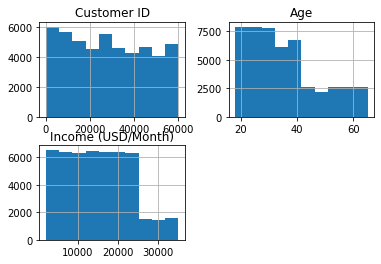

In [ ]:
datacustomer.hist()

1.4 Ahora procederemos con el análisis de datatransaction para finalmente fusionar los archivos. El datatransaction tiene 440098 filas y 3 columnas. La información más relevante que recopilamos aquí es que 263.998 usuarios pagaron con tarjeta y 176.103 clientes usaron efectivo. Lo fusionaremos para comprobar si existe una relación entre la ciudad y el modo de pago, por ejemplo.

In [ ]:
datatransaction.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [ ]:
counts = datatransaction['Payment_Mode'].value_counts()
counts

Card    263988
Cash    176103
Name: Payment_Mode, dtype: int64

In [ ]:
print(f'The number of rows are {datacab.shape[0]} \nand the number of columns are {datacab.shape[1]}')

print(f'The number of rows are {datacity.shape[0]} \nand the number of columns are {datacity.shape[1]}')

print(f'The number of rows are {datacustomer.shape[0]} \nand the number of columns are {datacustomer.shape[1]}')

print(f'The number of rows are {datatransaction.shape[0]} \nand the number of columns are {datatransaction.shape[1]}')


The number of rows are 359392 
and the number of columns are 7
The number of rows are 20 
and the number of columns are 3
The number of rows are 49171 
and the number of columns are 4
The number of rows are 440091 
and the number of columns are 3


In [ ]:
def missing(df):
    total=df.isnull().sum().sort_values(ascending=False)
    percent=(df.isnull().sum()*100/df.isnull().count()).sort_values(ascending=False)

missing(datacab)

missing(datacity)

missing(datacustomer)

missing(datatransaction)

datacab.isnull().sum()

datacity.isnull().sum()

datacustomer.isnull().sum()

datatransaction.isnull().sum()

Transaction ID    0
Customer ID       0
Payment_Mode      0
dtype: int64

In [ ]:
transactions = pd.merge(datacab, datatransaction, on='Transaction ID')
transactions

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card
1,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card
2,10000013,42371,Pink Cab,ATLANTA GA,9.04,125.20,97.6320,28712,Cash
3,10000014,42376,Pink Cab,ATLANTA GA,33.17,377.40,351.6020,28020,Cash
4,10000015,42372,Pink Cab,ATLANTA GA,8.73,114.62,97.7760,27182,Card
...,...,...,...,...,...,...,...,...,...
359380,10440101,43108,Yellow Cab,WASHINGTON DC,4.80,69.24,63.3600,52392,Cash
359381,10440104,43104,Yellow Cab,WASHINGTON DC,8.40,113.75,106.8480,53286,Cash
359382,10440105,43105,Yellow Cab,WASHINGTON DC,27.75,437.07,349.6500,52265,Cash
359383,10440106,43105,Yellow Cab,WASHINGTON DC,8.80,146.19,114.0480,52175,Card


In [ ]:
new = pd.merge(transactions, datacustomer, on='Customer ID')
new

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month)
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813
3,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237
4,10320494,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237
...,...,...,...,...,...,...,...,...,...,...,...,...
359380,10439790,43107,Yellow Cab,SEATTLE WA,16.66,261.18,213.9144,38520,Card,Female,42,19417
359381,10439799,43103,Yellow Cab,SILICON VALLEY,13.72,277.97,172.8720,12490,Cash,Male,33,18713
359382,10439838,43104,Yellow Cab,TUCSON AZ,19.00,303.77,232.5600,41414,Card,Male,38,3960
359383,10439840,43106,Yellow Cab,TUCSON AZ,5.60,92.42,70.5600,41677,Cash,Male,23,19454


In [ ]:
all = pd.merge(new, datacity, on='City')
all

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,814885,24701
1,10351127,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,814885,24701
2,10412921,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,814885,24701
3,10000012,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,814885,24701
4,10320494,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359380,10307228,43162,Yellow Cab,WASHINGTON DC,38.40,668.93,525.3120,51406,Cash,Female,29,6829,418859,127001
359381,10319775,43203,Yellow Cab,WASHINGTON DC,3.57,67.60,44.5536,51406,Cash,Female,29,6829,418859,127001
359382,10347676,43287,Yellow Cab,WASHINGTON DC,23.46,331.97,337.8240,51406,Card,Female,29,6829,418859,127001
359383,10358624,43314,Yellow Cab,WASHINGTON DC,27.60,358.23,364.3200,51406,Cash,Female,29,6829,418859,127001


In [ ]:
all.describe()

,Transaction ID,Date of Travel,KM Travelled,Price Charged,Cost of Trip,Customer ID,Age,Income (USD/Month),Population,Users
count,3.593850e+05,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,3.593850e+05,359385.000000
mean,1.022076e+07,42964.070999,22.567182,423.443065,286.190259,19191.879995,35.336756,15048.859958,3.132228e+06,158295.983383
std,1.268067e+05,307.469439,12.233523,274.380319,157.994334,21012.553299,12.594256,7969.330744,3.315220e+06,100957.127446
min,1.000001e+07,42371.000000,1.900000,15.600000,19.000000,1.000000,18.000000,2000.000000,2.489680e+05,927.000000
25%,1.011081e+07,42697.000000,12.000000,206.430000,151.200000,2705.000000,25.000000,8424.000000,6.712380e+05,80021.000000
50%,1.022104e+07,42988.000000,22.440000,386.360000,282.480000,7459.000000,33.000000,14685.000000,1.595037e+06,144132.000000
75%,1.033094e+07,43232.000000,32.960000,583.660000,413.683200,36078.000000,42.000000,21035.000000,8.405837e+06,302149.000000
max,1.044011e+07,43465.000000,48.000000,2048.030000,691.200000,60000.000000,65.000000,35000.000000,8.405837e+06,302149.000000


Ahora que hemos reunido todos los archivos en all, vamos chequear a ver si hay relaciones entre las variables. Primero vemos si hay relación entre income per month y cost of trip, hipótesis descartada. 

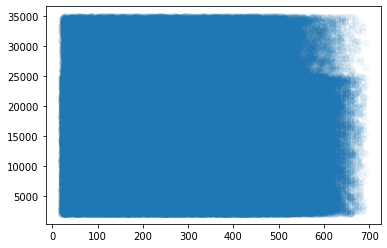

In [ ]:
plt.scatter(all['Cost of Trip'], all['Income (USD/Month)'],alpha=0.05)

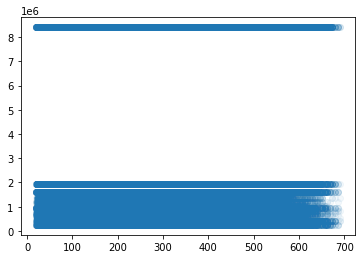

In [ ]:
plt.scatter(all['Cost of Trip'], all['Population'],alpha=0.05)

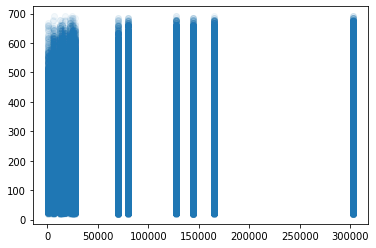

In [ ]:
plt.scatter(all['Users'], all['Cost of Trip'],alpha=0.05)

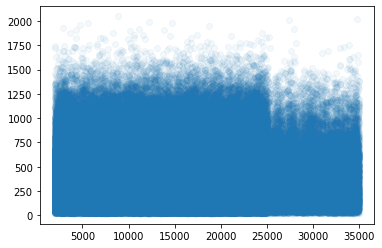

In [ ]:
plt.scatter(all['Income (USD/Month)'], all['Price Charged'],alpha=0.05)

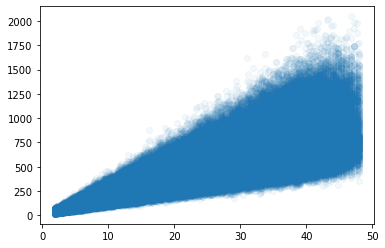

In [ ]:
plt.scatter(all['KM Travelled'], all['Price Charged'],alpha=0.05)

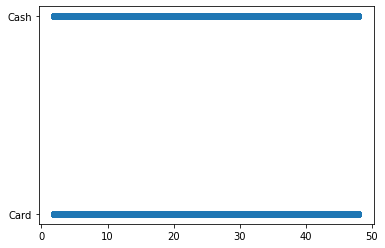

In [ ]:
plt.scatter(all['KM Travelled'], all['Payment_Mode'],alpha=0.05)

Procederemos a la transformación de las variables categóricas para poder utilizar los datos.

In [ ]:
all['Company'] = all['Company'].map({'Pink Cab': 0, 'Yellow Cab': 1})
all

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,0,ATLANTA GA,30.45,370.95,313.6350,29290,Card,Male,28,10813,814885,24701
1,10351127,43302,1,ATLANTA GA,26.19,598.70,317.4228,29290,Cash,Male,28,10813,814885,24701
2,10412921,43427,1,ATLANTA GA,42.55,792.05,597.4020,29290,Card,Male,28,10813,814885,24701
3,10000012,42375,0,ATLANTA GA,28.62,358.52,334.8540,27703,Card,Male,27,9237,814885,24701
4,10320494,43211,1,ATLANTA GA,36.38,721.10,467.1192,27703,Card,Male,27,9237,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359380,10307228,43162,1,WASHINGTON DC,38.40,668.93,525.3120,51406,Cash,Female,29,6829,418859,127001
359381,10319775,43203,1,WASHINGTON DC,3.57,67.60,44.5536,51406,Cash,Female,29,6829,418859,127001
359382,10347676,43287,1,WASHINGTON DC,23.46,331.97,337.8240,51406,Card,Female,29,6829,418859,127001
359383,10358624,43314,1,WASHINGTON DC,27.60,358.23,364.3200,51406,Cash,Female,29,6829,418859,127001


In [ ]:
all['City']= all['City'].map( {'NEW YORK NY': 0, 'CHICAGO IL': 1, 'LOS ANGELES CA': 2, 'WASHINGTON DC': 3,'BOSTON MA': 4, 'SAN DIEGO CA': 5, 'SILICON VALLEY': 6, 'SEATTLE WA': 7, 'ATLANTA GA': 8, 'DALLAS TX': 9, 'MIAMI FL': 10, 'AUSTIN TX': 11, 'ORANGE COUNTY': 12, 'DENVER CO': 13, 'NASHVILLE TN': 14, 'SACRAMENTO CA': 15, 'PHOENIX AZ': 16, 'TUCSON AZ': 17, 'PITTSBURGH PA': 18})#.astype(int)
all

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,0,8,30.45,370.95,313.6350,29290,Card,Male,28,10813,814885,24701
1,10351127,43302,1,8,26.19,598.70,317.4228,29290,Cash,Male,28,10813,814885,24701
2,10412921,43427,1,8,42.55,792.05,597.4020,29290,Card,Male,28,10813,814885,24701
3,10000012,42375,0,8,28.62,358.52,334.8540,27703,Card,Male,27,9237,814885,24701
4,10320494,43211,1,8,36.38,721.10,467.1192,27703,Card,Male,27,9237,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359380,10307228,43162,1,3,38.40,668.93,525.3120,51406,Cash,Female,29,6829,418859,127001
359381,10319775,43203,1,3,3.57,67.60,44.5536,51406,Cash,Female,29,6829,418859,127001
359382,10347676,43287,1,3,23.46,331.97,337.8240,51406,Card,Female,29,6829,418859,127001
359383,10358624,43314,1,3,27.60,358.23,364.3200,51406,Cash,Female,29,6829,418859,127001


In [ ]:
all['Payment_Mode'] = all['Payment_Mode'].map({'Card': 0, 'Cash': 1})

In [ ]:
all

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,0,8,30.45,370.95,313.6350,29290,0,Male,28,10813,814885,24701
1,10000012,42375,0,8,28.62,358.52,334.8540,27703,0,Male,27,9237,814885,24701
2,10320494,43211,1,8,36.38,721.10,467.1192,27703,0,Male,27,9237,814885,24701
3,10324737,43224,1,8,6.18,138.40,87.5088,27703,1,Male,27,9237,814885,24701
4,10000013,42371,0,8,9.04,125.20,97.6320,28712,1,Male,53,11242,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284834,10311299,43174,1,3,13.56,241.43,165.9744,52614,0,Female,44,8303,418859,127001
284835,10284072,43086,1,3,44.00,679.97,607.2000,51406,1,Female,29,6829,418859,127001
284836,10307228,43162,1,3,38.40,668.93,525.3120,51406,1,Female,29,6829,418859,127001
284837,10319775,43203,1,3,3.57,67.60,44.5536,51406,1,Female,29,6829,418859,127001


In [ ]:
all['Gender'] = all['Gender'].map({'Female': 0, 'Male': 1})
all

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Customer ID,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,10000011,42377,0,8,30.45,370.95,313.6350,29290,Card,1,28,10813,814885,24701
1,10351127,43302,1,8,26.19,598.70,317.4228,29290,Cash,1,28,10813,814885,24701
2,10412921,43427,1,8,42.55,792.05,597.4020,29290,Card,1,28,10813,814885,24701
3,10000012,42375,0,8,28.62,358.52,334.8540,27703,Card,1,27,9237,814885,24701
4,10320494,43211,1,8,36.38,721.10,467.1192,27703,Card,1,27,9237,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359380,10307228,43162,1,3,38.40,668.93,525.3120,51406,Cash,0,29,6829,418859,127001
359381,10319775,43203,1,3,3.57,67.60,44.5536,51406,Cash,0,29,6829,418859,127001
359382,10347676,43287,1,3,23.46,331.97,337.8240,51406,Card,0,29,6829,418859,127001
359383,10358624,43314,1,3,27.60,358.23,364.3200,51406,Cash,0,29,6829,418859,127001


In [ ]:
# quitaremos las variables que no vamos a utilizar

all = all.drop(['Transaction ID', 'Customer ID'],axis=1)
all

,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
0,42377,0,8,30.45,370.95,313.6350,Card,1,28,10813,814885,24701
1,43302,1,8,26.19,598.70,317.4228,Cash,1,28,10813,814885,24701
2,43427,1,8,42.55,792.05,597.4020,Card,1,28,10813,814885,24701
3,42375,0,8,28.62,358.52,334.8540,Card,1,27,9237,814885,24701
4,43211,1,8,36.38,721.10,467.1192,Card,1,27,9237,814885,24701
...,...,...,...,...,...,...,...,...,...,...,...,...
359380,43162,1,3,38.40,668.93,525.3120,Cash,0,29,6829,418859,127001
359381,43203,1,3,3.57,67.60,44.5536,Cash,0,29,6829,418859,127001
359382,43287,1,3,23.46,331.97,337.8240,Card,0,29,6829,418859,127001
359383,43314,1,3,27.60,358.23,364.3200,Cash,0,29,6829,418859,127001


In [ ]:
#con los datos completos, podemos proceder al análisis descriptivo, hacer una correlación y los historigramas

all.describe()


,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
count,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,359385.000000,3.593850e+05,359385.000000
mean,42964.070999,0.764308,3.113188,22.567182,423.443065,286.190259,0.400362,0.572945,35.336756,15048.859958,3.132228e+06,158295.983383
std,307.469439,0.424431,3.725904,12.233523,274.380319,157.994334,0.489972,0.494651,12.594256,7969.330744,3.315220e+06,100957.127446
min,42371.000000,0.000000,0.000000,1.900000,15.600000,19.000000,0.000000,0.000000,18.000000,2000.000000,2.489680e+05,927.000000
25%,42697.000000,1.000000,0.000000,12.000000,206.430000,151.200000,0.000000,0.000000,25.000000,8424.000000,6.712380e+05,80021.000000
50%,42988.000000,1.000000,2.000000,22.440000,386.360000,282.480000,0.000000,1.000000,33.000000,14685.000000,1.595037e+06,144132.000000
75%,43232.000000,1.000000,4.000000,32.960000,583.660000,413.683200,1.000000,1.000000,42.000000,21035.000000,8.405837e+06,302149.000000
max,43465.000000,1.000000,18.000000,48.000000,2048.030000,691.200000,1.000000,1.000000,65.000000,35000.000000,8.405837e+06,302149.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e926a2590>,
      dtype=object)

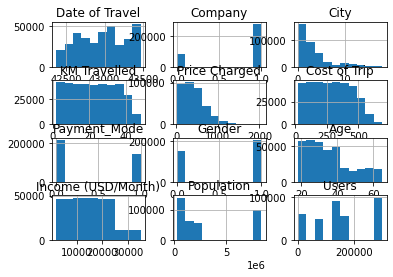

In [ ]:
all.hist()

In [ ]:
all.corr()

,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Population,Users
Date of Travel,1.000000,-0.020095,0.003685,-0.001618,-0.055559,-0.004484,-0.001461,-0.017247,-0.001348,-0.001370,0.022097,0.011752
Company,-0.020095,1.000000,-0.178230,0.000344,0.227996,0.133716,-0.001014,0.017280,0.000623,-0.000721,0.130909,0.180900
City,0.003685,-0.178230,1.000000,-0.002207,-0.156304,-0.025901,-0.001632,-0.063275,0.000547,-0.008865,-0.572739,-0.820891
KM Travelled,-0.001618,0.000344,-0.002207,1.000000,0.835752,0.981850,-0.000766,-0.001352,-0.000358,-0.000526,-0.002309,-0.000434
Price Charged,-0.055559,0.227996,-0.156304,0.835752,1.000000,0.859811,0.000228,0.012659,-0.003077,0.003240,0.326592,0.281031
Cost of Trip,-0.004484,0.133716,-0.025901,0.981850,0.859811,1.000000,-0.000896,0.000493,-0.000180,-0.000621,0.015108,0.023679
Payment_Mode,-0.001461,-0.001014,-0.001632,-0.000766,0.000228,-0.000896,1.000000,-0.000077,-0.001120,-0.000853,0.001547,0.001696
Gender,-0.017247,0.017280,-0.063275,-0.001352,0.012659,0.000493,-0.000077,1.000000,0.003378,-0.000985,0.043594,0.060890
Age,-0.001348,0.000623,0.000547,-0.000358,-0.003077,-0.000180,-0.001120,0.003378,1.000000,0.003901,-0.009004,-0.005842
Income (USD/Month),-0.001370,-0.000721,-0.008865,-0.000526,0.003240,-0.000621,-0.000853,-0.000985,0.003901,1.000000,0.011866,0.010480


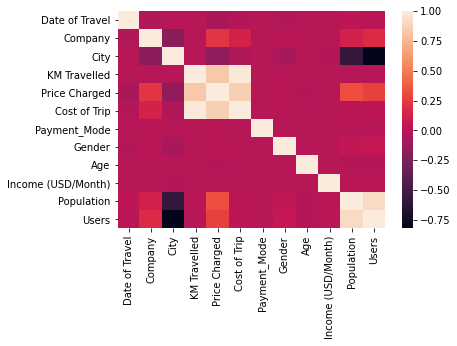

In [ ]:
import seaborn as sns
corr = all.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

Del análisis de correlación podemos ver que la edad y los ingresos no se relacionan con el resto de variables, siendo irrelevante si estamos haciendo un análisis lineal. Los más relevantes y relacionados entre sí son usuarios, población, precio cobrado, coste del viaje. Aunque la metodología correcta sería eliminar estas variables primero para construir nuestro modelo predictivo (que podemos determinar qué empresa tiene más valor definiendo si ciertas variables demográficas, geográficas y económicas son relevantes para dicha predicción) procederemos con todas las variables. Vamos intentar predecir la empresa que pertenence dada las características que hemos visto como inputs.

In [ ]:
X = all.drop('Company', axis=1)
Y = all.Company

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20)
X_val, X_test_test, Y_val, Y_test = train_test_split(X, Y, test_size=.20)
print("Datos iniciales\t\t:\t{}\n\t- X_train\t:\t{}\n\t- X_test\t:\t{}".format(len(X),len(X_train),len(X_test)))

Datos iniciales		:	284839
	- X_train	:	227871
	- X_test	:	56968


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=len(X_test))
print("Datos iniciales\t\t:\t{}\n\t- X_train\t:\t{}\n\t- X_val\t\t:\t{}\n\t- X_test\t:\t{}".format(len(X),len(X_train),len(X_val),len(X_test)))

Datos iniciales		:	284839
	- X_train	:	170903
	- X_val		:	56968
	- X_test	:	56968


In [ ]:
import sklearn
sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.2, train_size=0.8, random_state=42, shuffle=True, stratify=Y_train)


[        Transaction ID  Date of Travel  ...  Population   Users
 21719         10024506           42470  ...      248968   80021
 204555        10111807           42697  ...     8405837  302149
 122346        10171739           42862  ...     1595037  144132
 65185         10055022           42567  ...     1955130  164468
 133803        10170617           42860  ...     8405837  302149
 ...                ...             ...  ...         ...     ...
 106678        10068125           42603  ...     1595037  144132
 169396        10241372           43023  ...     8405837  302149
 126932        10026768           42480  ...     1339155   17675
 160756        10109602           42693  ...     8405837  302149
 161623        10133378           42735  ...     8405837  302149
 
 [136722 rows x 13 columns],
         Transaction ID  Date of Travel  ...  Population   Users
 84200         10267933           43069  ...      942908   22157
 273349        10188526           42913  ...      418859  1

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
classifier = KNeighborsClassifier()
cls = classifier.fit(X_train, Y_train)
prediction = cls.predict(X_test)

In [ ]:
cls_raw = classifier.fit(X_train, Y_train)
prediction_raw = cls_raw.predict(X_test)

In [ ]:
print("La tasa de acierto obtenida es {:.2f}%".format(100*accuracy_score(Y_test, prediction)))
print("La tasa de acierto obtenida es {:.2f}%".format(100*accuracy_score(Y_test, prediction_raw)))

La tasa de acierto obtenida es 68.37%
La tasa de acierto obtenida es 68.37%


In [ ]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD

In [ ]:
knn = NearestNeighbors(n_neighbors=11,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(vino_pivot_matrix)

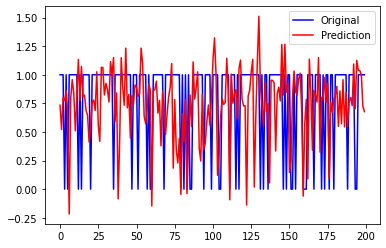

In [ ]:
from sklearn.linear_model import LinearRegression

model1 = LinearRegression().fit(X_train,Y_train)

Y_predict = model1.predict(X_test)
plt.plot(np.array(Y_test)[:200],'b')
plt.plot(Y_predict[:200],'r')
plt.legend(['Original', 'Prediction'])
plt.show()

In [ ]:
print("Bondad del ajuste en Train:\t{}".format(model1.score(X_train,Y_train)))
print("Bondad del ajuste en Test:\t{}".format(model1.score(X_test,Y_test)))

Bondad del ajuste en Train:	0.5368767218637915
Bondad del ajuste en Test:	-0.5495676216506225


In [ ]:
from sklearn.linear_model import Lasso
model2 = Lasso(alpha=1.0).fit(X_train,Y_train)

print("Bondad del ajuste en Train:\t{}".format(model2.score(X_train,Y_train)))
print("Bondad del ajuste en Test:\t{}".format(model2.score(X_test,Y_test)))

Bondad del ajuste en Train:	0.11840122974828304
Bondad del ajuste en Test:	-0.1030526745448397


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.20)
X_val, X_test_test, Y_val, Y_test = train_test_split(X, Y, test_size=.20)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=len(X_test))
print("Datos iniciales\t\t:\t{}\n\t- X_train\t:\t{}\n\t- X_test\t:\t{}".format(len(X),len(X_train),len(X_test)))

Datos iniciales		:	284839
	- X_train	:	170903
	- X_test	:	56968


In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier.fit(X_train, Y_train)
print("Bondad del ajuste en Train:\t{}".format(classifier.score(X_train,Y_train)))
print("Bondad del ajuste en Test:\t{}".format(classifier.score(X_test,Y_test)))

Bondad del ajuste en Train:	0.7613324517416312
Bondad del ajuste en Test:	0.7603742451902823


In [ ]:
from sklearn import neighbors
###se utiliza los parámetros default: distancia euclídea y k=5
model3 = neighbors.KNeighborsClassifier().fit(X_train, Y_train)

#predicción sobre la partición de test
Y_predict = model3.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score
acc_sklearn = accuracy_score(Y_test, Y_predict)

print("Acc (sklearn): {}".format(acc_sklearn))
print("Bondad del ajuste en Train:\t{}".format(model3.score(X_train,Y_train)))
print("Bondad del ajuste en Test:\t{}".format(model3.score(X_test,Y_test)))

Acc (sklearn): 0.6812772082572672
Bondad del ajuste en Train:	0.894577625904753
Bondad del ajuste en Test:	0.6812772082572672


In [ ]:
all1=all.copy()

In [ ]:
all3=all.copy()

In [ ]:
col = ['City','Gender','Price Charged']
all3 = all[col]
all3 = all.dropna(axis=0)
all3 = all3[all3['Price Charged'] <30]
all3 = all3.drop_duplicates(['City','Gender'])
all3_pivot = all3.pivot(index= 'City',columns='Gender',values='Price Charged').fillna(0)
all3_pivot_matrix = csr_matrix(all3_pivot)

In [ ]:
knn = NearestNeighbors(n_neighbors=11,algorithm= 'brute', metric= 'cosine')
model_knn = knn.fit(all3_pivot_matrix)

In [ ]:
query_index = np.random.choice(all3_pivot.shape[0])
distance, indice = model_knn.kneighbors(all3_pivot.iloc[query_index,:].values.reshape(1,-1),n_neighbors=11)
for i in range(0, len(distance.flatten())):
    if  i == 0:
        print('Recomendacion {0}:\n'.format(all3_pivot.index[query_index]))
    else:
        print('{0}: {1} with distance: {2}'.format(i,all3_pivot.index[indice.flatten()[i]],distance.flatten()[i]))

Recomendacion 4:

1: 16 with distance: 0.00010235725439788901
2: 2 with distance: 0.00015449730282135477
3: 15 with distance: 0.00018760581037446933
4: 10 with distance: 0.00037823388472901787
5: 3 with distance: 0.0005100775802473478
6: 18 with distance: 0.0006859429471932632
7: 12 with distance: 0.000811486154090435
8: 1 with distance: 0.0012104600671963839
9: 5 with distance: 0.0019514075293302069
10: 6 with distance: 0.0021093897878261547


In [ ]:
from sklearn import tree

#árbol de decisión importado con parámetros default
model4 = tree.DecisionTreeClassifier().fit(X_train,Y_train)

Y_predict = model4.predict(X_test)

print("Bondad del ajuste en Train:\t{}".format(model4.score(X_train,Y_train)))
print("Bondad del ajuste en Test:\t{}".format(model4.score(X_test,Y_test)))

Bondad del ajuste en Train:	1.0
Bondad del ajuste en Test:	0.6424029940036451


In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm

In [ ]:
model = svm.SVC().fit(X_train,Y_train)
Y_predict = model.predict(X_test)
print("Acc: {}".format(accuracy_score(Y_test, Y_predict)))

Del análisis podemos ver que el que mejor desempeño es la regresión logística (en test), lo que tiene sentido dado que estamos clasificando en dos variables categóricas (empresa rosa y empresa amarilla), seguido por KNN y random forest. El SVC podría tener un desempeño superior a la regresión dado que posiblemente la relación no sea lineal (con rfb) pero mi ordenador ha trabado intentando rodar el SVC.

Comparamos los modelos estadísticamente

In [ ]:
pip install mlxtend

In [ ]:
import scipy.stats as stats

In [ ]:
sample1 = model1.score(X_test,Y_test)
sample2 = model2.score(X_test,Y_test)
t_stat, p_val = stats.ttest_ind(sample1, sample2, equal_var=False)


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
seed = 7

In [ ]:
models = []
models.append(('Model1', LogisticRegression()))
models.append(('Model2', Lasso()))
models.append(('Model3', LogisticRegression()))



** ver modelos que funcionan mejor

prepararemos una red neuronal

In [ ]:
target = all.pop('Company')

In [ ]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((all.values, target.values))

In [ ]:
for feat, targ in dataset.take(5):
  print ('Features: {}, Target: {}'.format(feat, targ))

Features: [4.23770e+04 8.00000e+00 3.04500e+01 3.70950e+02 3.13635e+02 0.00000e+00
 1.00000e+00 2.80000e+01 1.08130e+04 8.14885e+05 2.47010e+04], Target: 0
Features: [4.330200e+04 8.000000e+00 2.619000e+01 5.987000e+02 3.174228e+02
 1.000000e+00 1.000000e+00 2.800000e+01 1.081300e+04 8.148850e+05
 2.470100e+04], Target: 1
Features: [4.34270e+04 8.00000e+00 4.25500e+01 7.92050e+02 5.97402e+02 0.00000e+00
 1.00000e+00 2.80000e+01 1.08130e+04 8.14885e+05 2.47010e+04], Target: 1
Features: [4.23750e+04 8.00000e+00 2.86200e+01 3.58520e+02 3.34854e+02 0.00000e+00
 1.00000e+00 2.70000e+01 9.23700e+03 8.14885e+05 2.47010e+04], Target: 0
Features: [4.321100e+04 8.000000e+00 3.638000e+01 7.211000e+02 4.671192e+02
 0.000000e+00 1.000000e+00 2.700000e+01 9.237000e+03 8.148850e+05
 2.470100e+04], Target: 1


In [ ]:
train_dataset = dataset.shuffle(len(all)).batch(64)

In [ ]:
def get_compiled_model():
    model = tf.keras.Sequential([
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1)
  ])

    model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
    return model

In [ ]:
model = get_compiled_model()
model.fit(train_dataset, epochs=15)

Epoch 1/15
5616/5616 [==============================] - 9s 1ms/step - loss: 25854.8793 - accuracy: 0.6540
Epoch 2/15
5616/5616 [==============================] - 9s 1ms/step - loss: 983.7171 - accuracy: 0.6713
Epoch 3/15
5616/5616 [==============================] - 8s 1ms/step - loss: 824.0585 - accuracy: 0.6800
Epoch 4/15
5616/5616 [==============================] - 8s 1ms/step - loss: 723.6541 - accuracy: 0.6854
Epoch 5/15
5616/5616 [==============================] - 8s 1ms/step - loss: 681.6743 - accuracy: 0.6872
Epoch 6/15
5616/5616 [==============================] - 8s 1ms/step - loss: 564.5427 - accuracy: 0.6898
Epoch 7/15
5616/5616 [==============================] - 8s 1ms/step - loss: 442.8404 - accuracy: 0.6971
Epoch 8/15
5616/5616 [==============================] - 8s 1ms/step - loss: 467.6964 - accuracy: 0.6943
Epoch 9/15
5616/5616 [==============================] - 8s 1ms/step - loss: 409.8279 - accuracy: 0.6981
Epoch 10/15
5616/5616 [==============================] - 9s 1m

In [ ]:
# Hemos alcanzado una accuracy del 70,65%.  Ahora trabajaremos con q-learning y aprendizaje por refuerzo

El aprendizaje por refuerzo es una categoría particular de aprendizaje automático (no está clasificado ni como supervisado ni como no supervisado) que se aplica a cómo los agentes deben desempeñar acciones en un determinado entorno. Cuando realizan acciones, el estado del entorno cambia a un nuevo estado y el agente recibe una recompensa o una penalización, de acuerdo con la acción que haya elegido. El aprendizaje por refuerzo tiene como objetivo hacer que este agente aprenda de su experiencia (que en en el script son las interacciones) con el entorno para seleccionar acciones que maximicen la suma de recompensas que recibe del entorno. El aprendizaje automático consiste en encontrar un balance entre exploración (algo que no se sabe/ que es como entrar en un nuevo territorio) con explotación (algo que ya se tiene conocimiento/cuando trabajamos en un territorio ya conocido).

Los elementos que constituyen un algoritmo de aprendizaje por refuerzon son los siguientes:



* Entorno: es el ambiente en que se mueve el agente. El entorno considera el actual estado del agente y su acción como un input y nos da un output que es la recompensa (o castigo) en el próximo estado. 
* Agente: un agente es el que ejecuta las acciones que serán desempeñadas en el entorno, siendo el propio algoritmo. 
* Acción (A): es el conjunto de todos los movimientos posibles que un agente puede hacer. El agente elige entre una serie (lista) de acciones posibles que maximiza la recompensa en el futuro, dado el estado que se encuentra en el presente. 
* Estado (S): es la situación presente del agente.
* Recompensa (R): es la respuesta por la cual medimos el éxito o fracaso de las acciones de un agente. Es una forma de evaluación de las acciones del agente.
* Política (π): La política es la estrategia que el agente emplea para determinar cuál será su próxima acción basada en el estado actual. Mapea los estados en acciones. 
* Factor de descuento (γ): Se multiplica por las futuras recompesas a medida que son descubiertos por los agentes para reducir los efectos de las recompensas en la elección del agente. Son diseñados para que una recompensa futura valgan menos que una presente por ejemplo, reenforzando acciones de corto plazo. 
*Valor (V): El benefício de largo plazo esperado, contabilizando el descuento, a diferencia de la recompensa de corto plazo (R).  Vπ(s) es el benefício de largo plazo esperando bajo una política actual π. Se descuenta las recompensas lo más a futuro que está su posición. 
* Q-value (Q): Q-value es semejante al valor V pero lleva en consideración un parámetro extra, la acción actual A.  Qπ(s, a) es el benefício de largo plazo del actual estado S, a través de la acción A bajo la política π. El valor Q mapea los pares estados-acción (S, A) para obtener recompensas. 

* S: Conjunto de observaciones. El agente puede selecionar una acción para interactuar con el entorno.

El objetivo del aprendizaje por refuerzo es conseguir la máxima recompensa posible, resolviendo el problema de Markov Decision Process al encontrar la política óptima (que es encontrar la secuencia de acciones que maximiza el total de recompensas). 

La principal diferencia entre la programación dinámica clásica y el aprendizaje por refuerzo es que este no asume ningún conocimiento del modelo del Markov Decision process y pueden ser aplicados a grandes MDPs, donde los primeros métodos no serían posibles de ser aplicados.

Las reglas suelen ser estocásticas e involucran una recompensa inmediata y escalar que está asociada por el último estado (MDP). 
)



In [ ]:
#primero empezamos como si fueran la misma empresa  

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class Agent():
    def __init__(self):
        self.truth_mat = np.matrix(np.full((2048,2048),None))
        self.guess_mat = np.matrix(np.full((2048,2048),None))
        self.reward_mat = np.matrix(np.full((2048,2048),None)) 

        self.x = []
        self.y = []
        self.counter = 0

    def reset(self):
        '''
        reset the agent
        '''
        self.truth_mat = np.matrix(np.full((2048,2048),None))
        self.guess_mat = np.matrix(np.full((2048,2048),None))
        self.reward_mat = np.matrix(np.full((2048,2048),None))
        self.x = []
        self.y = []
        self.counter = 0

    @staticmethod
    def guess(a,b):
        '''
        returns random guess of the sum a + b
        '''
        return np.random.randint(0,11)
    
    def ask(self,a,b):
        '''
        ask the agent the sum of two numbers
        '''
        return self.guess_mat[a,b]

    def run_rnd(self,step=None,verbose=False):
        '''
        The agent learns how to sum two numbers included in [0,5]
        cycle over all elements of matrices, for each element randomly guess a
        sum, evaluate the true sum and calculate the difference (reward).
        All the informations are stored in agent's memory in the form of
        matrices.
        Params:
            step: (int) execute a given number of cycles. Learning can be
                  examined through *_mat variables and resumed later
            verbose: print the reward matrix each timestep
        Returns a plot of the average reward (y) over timesteps(x)
        '''
        if step:
            for _ in range(step):
                for i in range(2048):
                    for j in range(2048):
                        self.truth_mat[i,j] = i + j
                        if self.reward_mat[i,j] != 0:
                            self.guess_mat[i,j] = self.guess(i,j)
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                self.counter += 1
                self.x.append(self.counter)
                self.y.append(np.sum(np.abs(self.reward_mat)))
                print('Cycle:{} Reward average:{:.3f} Error:{}'.format(self.counter,np.mean(self.reward_mat),np.sum(np.abs(self.reward_mat))))
                if verbose:
                    print('Reward matrix:\n',self.reward_mat,end='\n\n')   
        else:
            while np.all(self.reward_mat == 0) == False:
                for i in range(2048):
                    for j in range(2048):
                        self.truth_mat[i,j] = i + j
                        if self.reward_mat[i,j] != 0:
                            self.guess_mat[i,j] = self.guess(i,j)
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                self.counter += 1
                self.x.append(self.counter)
                self.y.append(np.sum(np.abs(self.reward_mat)))
                print('Cycle:{} Reward average:{:.3f} Error:{}'.format(self.counter,np.mean(self.reward_mat),np.sum(np.abs(self.reward_mat))))
                if verbose:
                    print('Reward matrix:\n',self.reward_mat,end='\n\n')   
        fig, ax = plt.subplots()
        ax.plot(self.x,self.y)
        ax.set_title('Run Random')
        ax.set_xlabel('Cycles')
        ax.set_ylabel('Error')
        return plt.show()
        return plt.show()

    def run_smart(self,step=None,verbose=True):
        '''
        The agent learns how to sum two numbers included in [0,5],
        cycle over all elements of matrices.
        For each element: if the reward is not set take a guess,
        evaluate the true sum and calculate the reward),
        if the reward is negative increase the previous guess by 1,
        if the reward is positive decrease the
        previous guess by 1. All the informations are stored in agent's memory 
        in the form of matrices.
        Params:
            step: (int) execute a given number of cycles. Learning can be
                  examined through *_mat variables and resumed later
            verbose: print the reward matrix each timestep
        Returns a plot of the average reward (y) over timesteps(x)
        '''
        if step:
            for _ in range(step):
                for i in range(2048):
                    for j in range(2048):
                        self.truth_mat[i,j] = i + j
                        if self.reward_mat[i,j] == None:
                            self.guess_mat[i,j] = self.guess(i,j)
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                        elif self.reward_mat[i,j] > 0:
                            self.guess_mat[i,j] -= 1
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                        elif self.reward_mat[i,j] < 0:
                            self.guess_mat[i,j] += 1
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                self.counter += 1
                self.x.append(self.counter)
                self.y.append(np.sum(np.abs(self.reward_mat)))
                print('Cycle:{} Reward average:{:.3f} Error:{}'.format(self.counter,np.mean(self.reward_mat),np.sum(np.abs(self.reward_mat))))
                if verbose:
                    print('Reward matrix:\n',self.reward_mat,end='\n\n')
        else:
            while np.all(self.reward_mat == 0) == False:
                for i in range(2048):
                    for j in range(2048):
                        self.truth_mat[i,j] = i + j
                        if self.reward_mat[i,j] == None:
                            self.guess_mat[i,j] = self.guess(i,j)
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                        elif self.reward_mat[i,j] > 0:
                            self.guess_mat[i,j] -= 1
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                        elif self.reward_mat[i,j] < 0:
                            self.guess_mat[i,j] += 1
                            self.reward_mat[i,j] = self.guess_mat[i,j] - self.truth_mat[i,j]
                self.counter += 1
                self.x.append(self.counter)
                self.y.append(np.sum(np.abs(self.reward_mat)))                
                print('Cycle:{} Reward average:{:.3f} Error:{}'.format(self.counter,np.mean(self.reward_mat),np.sum(np.abs(self.reward_mat))))
                if verbose:
                    print('Reward matrix:\n',self.reward_mat,end='\n\n')
        fig, ax = plt.subplots()
        ax.plot(self.x,self.y)
        ax.set_title('Run Smart')
        ax.set_xlabel('Cycles')
        ax.set_ylabel('Error')
        return plt.show()

In [ ]:
new = Agent()
new.run_rnd()

Cycle:1 Reward average:-2041.998 Error:8564761480
Cycle:2 Reward average:-2041.999 Error:8564764953
Cycle:3 Reward average:-2041.997 Error:8564755645
Cycle:4 Reward average:-2041.999 Error:8564765291
Cycle:5 Reward average:-2042.000 Error:8564768446
Cycle:6 Reward average:-2042.001 Error:8564773676
Cycle:7 Reward average:-2041.999 Error:8564763504
Cycle:8 Reward average:-2041.998 Error:8564759372
Cycle:9 Reward average:-2041.999 Error:8564765598
Cycle:10 Reward average:-2041.997 Error:8564755104
Cycle:11 Reward average:-2041.997 Error:8564756840
Cycle:12 Reward average:-2041.999 Error:8564762663
Cycle:13 Reward average:-2041.999 Error:8564763523
Cycle:14 Reward average:-2042.001 Error:8564772277


KeyboardInterrupt: ignored

In [ ]:
new.reset()
new.run_smart()

Cycle:1 Reward average:-2042.001 Error:8564772985
Reward matrix:
 [[0 0 5 ... -2035 -2040 -2043]
 [5 6 3 ... -2045 -2047 -2044]
 [3 0 -3 ... -2041 -2048 -2044]
 ...
 [-2038 -2042 -2040 ... -4087 -4090 -4082]
 [-2038 -2045 -2038 ... -4089 -4091 -4086]
 [-2039 -2043 -2040 ... -4088 -4090 -4093]]

Cycle:2 Reward average:-2041.001 Error:8560578690
Reward matrix:
 [[0 0 4 ... -2034 -2039 -2042]
 [4 5 2 ... -2044 -2046 -2043]
 [2 0 -2 ... -2040 -2047 -2043]
 ...
 [-2037 -2041 -2039 ... -4086 -4089 -4081]
 [-2037 -2044 -2037 ... -4088 -4090 -4085]
 [-2038 -2042 -2039 ... -4087 -4089 -4092]]

Cycle:3 Reward average:-2040.001 Error:8556384404
Reward matrix:
 [[0 0 3 ... -2033 -2038 -2041]
 [3 4 1 ... -2043 -2045 -2042]
 [1 0 -1 ... -2039 -2046 -2042]
 ...
 [-2036 -2040 -2038 ... -4085 -4088 -4080]
 [-2036 -2043 -2036 ... -4087 -4089 -4084]
 [-2037 -2041 -2038 ... -4086 -4088 -4091]]

Cycle:4 Reward average:-2039.001 Error:8552190132
Reward matrix:
 [[0 0 2 ... -2032 -2037 -2040]
 [2 3 0 ... -20

KeyboardInterrupt: ignored

In [ ]:
import math 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import pandas as pd
from matplotlib import animation, rc

!pip install qbstyles
from qbstyles import mpl_style
mpl_style(dark=False)

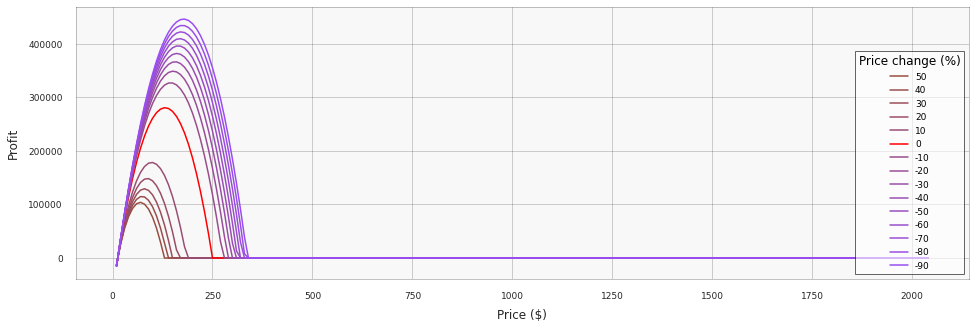

In [ ]:

## Environment simulator
def plus(x):
  return 0 if x < 0 else x

def minus(x):
  return 0 if x > 0 else -x

def shock(x):
  return np.sqrt(x)

# Demand at time step t for current price p_t and previous price p_t_1
def q_t(p_t, p_t_1, q_0, k, a, b):
  return plus(q_0 - k*p_t - a*shock(plus(p_t - p_t_1)) + b*shock(minus(p_t - p_t_1)))

# Profit at time step t
def profit_t(p_t, p_t_1, q_0, k, a, b, unit_cost):
  return q_t(p_t, p_t_1, q_0, k, a, b)*(p_t - unit_cost) 

# Total profit for price vector p over len(p) time steps
def profit_total(p, unit_cost, q_0, k, a, b):
  return profit_t(p[0], p[0], q_0, k, 0, 0, unit_cost) + sum(map(lambda t: profit_t(p[t], p[t-1], q_0, k, a, b, unit_cost), range(len(p))))

## Environment parameters
T = 4
price_max = 2048
price_step = 10
q_0 = 5000
k = 20
unit_cost = 13
a_q = 300
b_q = 100

## Partial bindings for readability
def profit_t_response(p_t, p_t_1):
  return profit_t(p_t, p_t_1, q_0, k, a_q, b_q, unit_cost)

def profit_response(p):
  return profit_total(p, unit_cost, q_0, k, a_q, b_q)

## Visualize price-demand functions
price_grid = np.arange(price_step, price_max, price_step)
price_change_grid = np.arange(0.5, 2.0, 0.1)
profit_map = np.zeros( (len(price_grid), len(price_change_grid)) )
for i in range(len(price_grid)):
  for j in range(len(price_change_grid)):
    profit_map[i,j] = profit_t_response(price_grid[i], price_grid[i]*price_change_grid[j])

plt.figure(figsize=(16, 5))
for i in range(len(price_change_grid)):
  if math.isclose(price_change_grid[i], 1.0):
    color = 'red'
  else:
    color = (0.6, 0.3, price_change_grid[i]/2.0)
  plt.plot(price_grid, profit_map[:, i], c=color)
plt.xlabel("Price ($)")
plt.ylabel("Profit")
plt.legend(np.int_(np.round((1-price_change_grid)*100)), loc='lower right', title="Price change (%)", fancybox=False, framealpha=0.6)

In [ ]:

# Find optimal constant price

profits = np.array([ profit_response(np.repeat(p, T)) for p in price_grid ])
p_idx = np.argmax(profits)
price_opt_const = price_grid[p_idx]

print(f'Optimal price is {price_opt_const}, achieved profit is {profits[p_idx]}')

Optimal price is 130, achieved profit is 1404000.0


[ 130 2040  240 2040]
Achieved profit is 2081410.9331479222


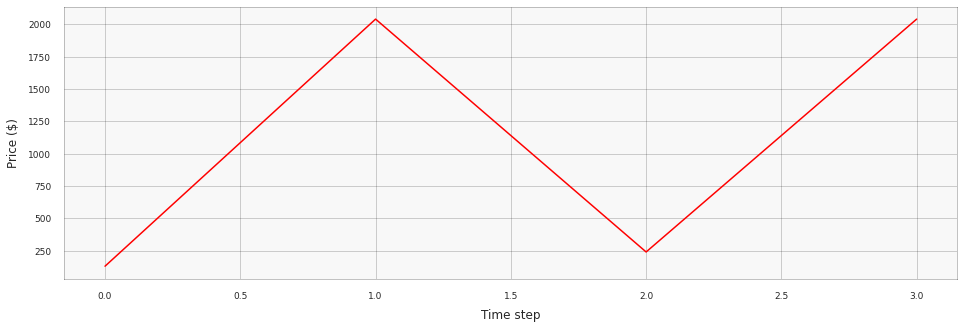

In [ ]:
# Find optimal sequence of prices using greedy search

def find_optimal_price_t(p_baseline, price_grid, t):
  p_grid = np.tile(p_baseline, (len(price_grid), 1))
  p_grid[:, t] = price_grid
  profit_grid = np.array([ profit_response(p) for p in p_grid ])
  return price_grid[ np.argmax(profit_grid) ]

p_opt = np.repeat(price_opt_const, T)
for t in range(T):
  price_t = find_optimal_price_t(p_opt, price_grid, t)
  p_opt[t] = price_t

print(p_opt)
print(f'Achieved profit is {profit_response(p_opt)}')

plt.figure(figsize=(16, 5))
plt.xlabel("Time step")
plt.ylabel("Price ($)")
plt.plot(range(len(p_opt)), p_opt, c='red')

In [ ]:
# Visualization functions

from bokeh.io import show, output_notebook
from bokeh.palettes import PuBu4
from bokeh.plotting import figure
from bokeh.models import Label

output_notebook()

def plot_return_trace(returns, smoothing_window=10, range_std=2):
  plt.figure(figsize=(16, 5))
  plt.xlabel("Episode")
  plt.ylabel("Return ($)")
  returns_df = pd.Series(returns)
  ma = returns_df.rolling(window=smoothing_window).mean()
  mstd = returns_df.rolling(window=smoothing_window).std()
  plt.plot(ma, c = 'blue', alpha = 1.00, linewidth = 1)
  plt.fill_between(mstd.index, ma-range_std*mstd, ma+range_std*mstd, color='blue', alpha=0.2)

def plot_price_schedules(p_trace, sampling_ratio, last_highlights, fig_number=None):
  plt.figure(fig_number);
  plt.xlabel("Time step");
  plt.ylabel("Price ($)");
  plt.plot(range(T), np.array(p_trace[0:-1:sampling_ratio]).T, c = 'k', alpha = 0.05)
  return plt.plot(range(T), np.array(p_trace[-(last_highlights+1):-1]).T, c = 'red', alpha = 0.5, linewidth=2)

def bullet_graph(data, labels=None, bar_label=None, axis_label=None,
                size=(5, 3), palette=None, bar_color="black", label_color="gray"):
    stack_data = np.stack(data[:,2])

    cum_stack_data = np.cumsum(stack_data, axis=1)
    h = np.max(cum_stack_data) / 20

    fig, axarr = plt.subplots(len(data), figsize=size, sharex=True)

    for idx, item in enumerate(data):

        if len(data) > 1:
            ax = axarr[idx]

        ax.set_aspect('equal')
        ax.set_yticklabels([item[0]])
        ax.set_yticks([1])
        ax.spines['bottom'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)

        prev_limit = 0
        for idx2, lim in enumerate(cum_stack_data[idx]):
            ax.barh([1], lim - prev_limit, left=prev_limit, height=h, color=palette[idx2])
            prev_limit = lim
        rects = ax.patches
        ax.barh([1], item[1], height=(h / 3), color=bar_color)

    if labels is not None:
        for rect, label in zip(rects, labels):
            height = rect.get_height()
            ax.text(
                rect.get_x() + rect.get_width() / 2,
                -height * .4,
                label,
                ha='center',
                va='bottom',
                color=label_color)
            
    if bar_label is not None:
        rect = rects[0]
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width(),
            -height * .1,
            bar_label,
            ha='center',
            va='bottom',
            color='white')
    if axis_label:
        ax.set_xlabel(axis_label)
    fig.subplots_adjust(hspace=0)

Ahora empezamos con DQN

Episode 980 of 1000 (98.00%)
Best profit results: 1972706.060133162
Best profit results: 1972706.060133162
Best profit results: 1974634.1827644506
Best profit results: 1974634.1827644506
Best profit results: 1974634.1827644506
Best profit results: 1977323.8287841384
Best profit results: 1977323.8287841384
Best profit results: 1977323.8287841384
Best profit results: 1977323.8287841384
Best profit results: 1977323.8287841384


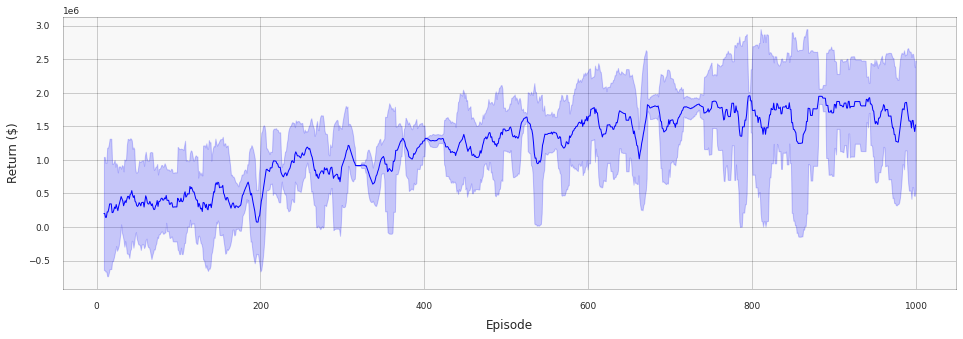

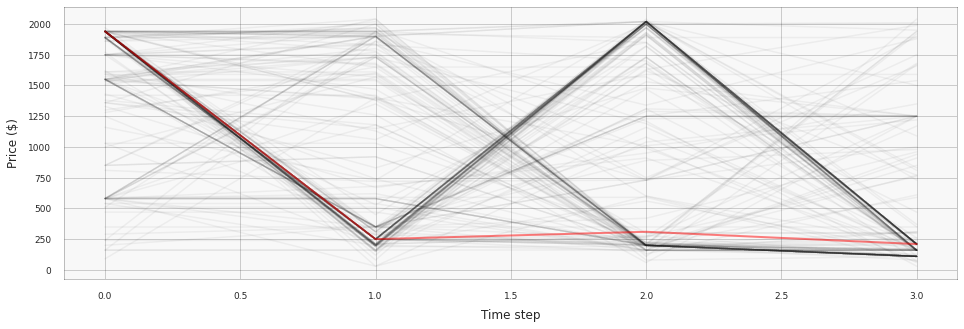

In [ ]:
import math
import random
import numpy as np
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count
import torch.nn.functional as F

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# A cyclic buffer of bounded size that holds the transitions observed recently
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

class PolicyNetworkDQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
      super(PolicyNetworkDQN, self).__init__()
      layers = [
              nn.Linear(state_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, hidden_size),
              nn.ReLU(),
              nn.Linear(hidden_size, action_size)
      ]
      self.model = nn.Sequential(*layers)

    def forward(self, x):
      q_values = self.model(x)
      return q_values  

class AnnealedEpsGreedyPolicy(object):
  def __init__(self, eps_start = 0.9, eps_end = 0.05, eps_decay = 400):
    self.eps_start = eps_start
    self.eps_end = eps_end
    self.eps_decay = eps_decay
    self.steps_done = 0

  def select_action(self, q_values):
    sample = random.random()
    eps_threshold = self.eps_end + (self.eps_start - self.eps_end) * math.exp(-1. * self.steps_done / self.eps_decay)
    self.steps_done += 1
    if sample > eps_threshold:
        return np.argmax(q_values)
    else:
        return random.randrange(len(q_values))

GAMMA = 1.00
TARGET_UPDATE = 20
BATCH_SIZE = 512

def update_model(memory, policy_net, target_net):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.stack(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)

    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

    # Compute the expected Q values
    expected_state_action_values = reward_batch[:, 0] + (GAMMA * next_state_values)  

    # Compute Huber loss
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

def env_intial_state():
  return np.repeat(0, 2*T)

def env_step(t, state, action):
  next_state = np.repeat(0, len(state))
  next_state[0] = price_grid[action]
  next_state[1:T] = state[0:T-1]
  next_state[T+t] = 1
  reward = profit_t_response(next_state[0], next_state[1])
  return next_state, reward

def to_tensor(x):
  return torch.from_numpy(np.array(x).astype(np.float32))

def to_tensor_long(x):
  return torch.tensor([[x]], device=device, dtype=torch.long)

policy_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
target_net = PolicyNetworkDQN(2*T, len(price_grid)).to(device)
optimizer = optim.AdamW(policy_net.parameters(), lr = 0.005)
policy = AnnealedEpsGreedyPolicy()
memory = ReplayMemory(10000)

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

num_episodes = 1000
return_trace = []
p_trace = [] # price schedules used in each episode
for i_episode in range(num_episodes):
    state = env_intial_state()
    reward_trace = []
    p = []
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
          q_values = policy_net(to_tensor(state))
        action = policy.select_action(q_values.detach().numpy())

        next_state, reward = env_step(t, state, action)

        # Store the transition in memory
        memory.push(to_tensor(state), 
                    to_tensor_long(action), 
                    to_tensor(next_state) if t != T - 1 else None, 
                    to_tensor([reward]))

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the target network)
        update_model(memory, policy_net, target_net)

        reward_trace.append(reward)
        p.append(price_grid[action])

    return_trace.append(sum(reward_trace))
    p_trace.append(p)

    # Update the target network, copying all weights and biases in DQN
    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait = True)
        print(f'Episode {i_episode} of {num_episodes} ({i_episode/num_episodes*100:.2f}%)')

plot_return_trace(return_trace)

fig = plt.figure(figsize=(16, 5))
plot_price_schedules(p_trace, 5, 1, fig.number)

for profit in sorted(profit_response(s) for s in p_trace)[-10:]:
  print(f'Best profit results: {profit}')

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texlive-base-bin transfig ufraw-batch inkscape libjxr-tools
  libwmf0.2-7-gtk poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono g

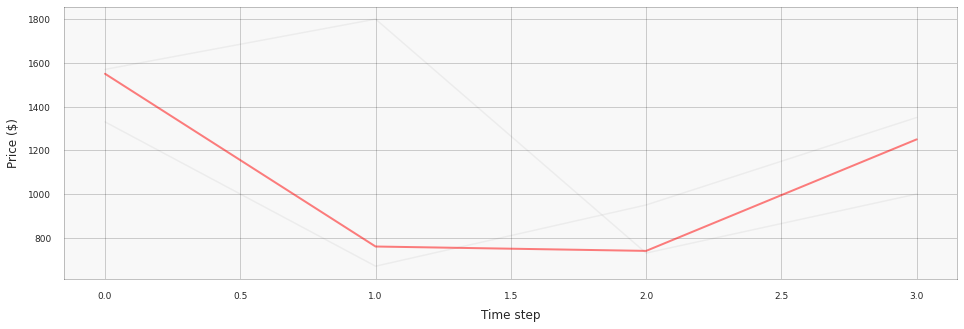

In [ ]:
# Render and save the animation of the simulation process
!apt install imagemagick

plt.ioff()
fig = plt.figure(figsize=(16, 5))
def animate(t):
  fig.clear()
  plot_price_schedules(p_trace[0:t], 5, 1, fig.number)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=range(10, 100, 10), interval=50, blit=False, repeat_delay=500)
ani.save('sim.gif', dpi=80, writer='imagemagick', fps=20)
rc('animation', html='jshtml')
ani

In [ ]:
# Debugging Q-values computations

transitions = memory.sample(10)
batch = Transition(*zip(*transitions))

non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
non_final_next_states = torch.stack([s for s in batch.next_state if s is not None])

state_batch = torch.stack(batch.state)
action_batch = torch.cat(batch.action)
reward_batch = torch.stack(batch.reward)

state_action_values = policy_net(state_batch).gather(1, action_batch)

next_state_values = torch.zeros(len(transitions), device=device)
next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()

expected_state_action_values = (next_state_values * GAMMA) + reward_batch[:, 0]

q_trace = []
for t in range(len(transitions)):
  print(f"Q_(s,a)[ {expected_state_action_values[t]} ] = r [ {reward_batch[t].item()} ] + g*Q_(s+1)[ {next_state_values[t]} ]  <> Q_(s,a)[ {state_action_values[t].item()} ]")
  q_trace.append([f"Sample {t}", state_action_values[t].item(), [reward_batch[t].item(), next_state_values[t]]])

Q_(s,a)[ 1088558.25 ] = r [ 0.0 ] + g*Q_(s+1)[ 1088558.25 ]  <> Q_(s,a)[ 1138126.625 ]
Q_(s,a)[ 1957891.25 ] = r [ 0.0 ] + g*Q_(s+1)[ 1957891.25 ]  <> Q_(s,a)[ 1961431.875 ]
Q_(s,a)[ 1388551.75 ] = r [ 493402.25 ] + g*Q_(s+1)[ 895149.5 ]  <> Q_(s,a)[ 1500459.375 ]
Q_(s,a)[ 1000023.1875 ] = r [ 0.0 ] + g*Q_(s+1)[ 1000023.1875 ]  <> Q_(s,a)[ 1151593.875 ]
Q_(s,a)[ 377858.1875 ] = r [ 377858.1875 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 396067.8125 ]
Q_(s,a)[ 1957891.25 ] = r [ 0.0 ] + g*Q_(s+1)[ 1957891.25 ]  <> Q_(s,a)[ 1961431.875 ]
Q_(s,a)[ 363622.28125 ] = r [ 363622.28125 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 276177.53125 ]
Q_(s,a)[ 0.0 ] = r [ 0.0 ] + g*Q_(s+1)[ 0.0 ]  <> Q_(s,a)[ 5586.0078125 ]
Q_(s,a)[ 2146855.5 ] = r [ 0.0 ] + g*Q_(s+1)[ 2146855.5 ]  <> Q_(s,a)[ 2151171.75 ]
Q_(s,a)[ 2146855.5 ] = r [ 0.0 ] + g*Q_(s+1)[ 2146855.5 ]  <> Q_(s,a)[ 2151171.75 ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


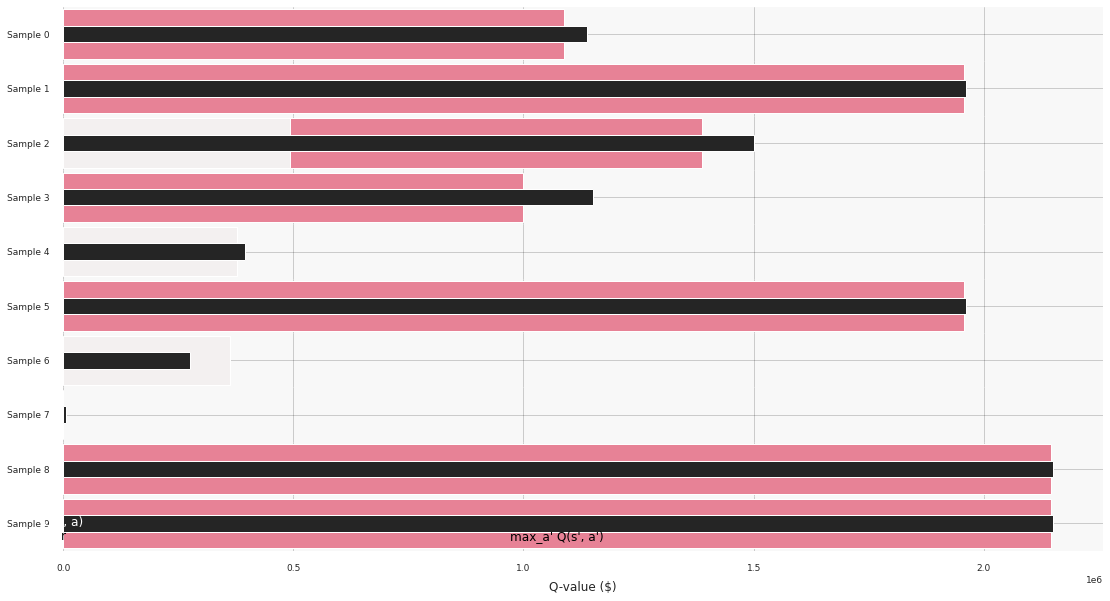

In [ ]:
# Visualization of the debugging infomation for Q-values 

palette = sns.light_palette("crimson", 3, reverse=False)
bullet_graph(np.array(q_trace),
            labels=["r", "max_a' Q(s', a')"], bar_label="Q(s, a)", size=(20, 10),
            axis_label="Q-value ($)", label_color="black",
            bar_color="#252525", palette=palette)

In [ ]:
num_episodes = 100
return_trace = []
q_values_rewards_trace = np.zeros((num_episodes, T, 2, ))
for i_episode in range(num_episodes):
    state = env_intial_state()
    for t in range(T):
        # Select and perform an action
        with torch.no_grad():
          q_values = policy_net(to_tensor(state)).detach().numpy()
        action = policy.select_action(q_values)

        next_state, reward = env_step(t, state, action)

        # Move to the next state
        state = next_state

        q_values_rewards_trace[i_episode][t][0] = q_values[action]
        for tau in range(t):
          q_values_rewards_trace[i_episode][tau][1] += reward * (GAMMA ** (t - tau))

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1185: UserWarning: The following kwargs were not used by contour: 'aspect'
  **contour_kws,


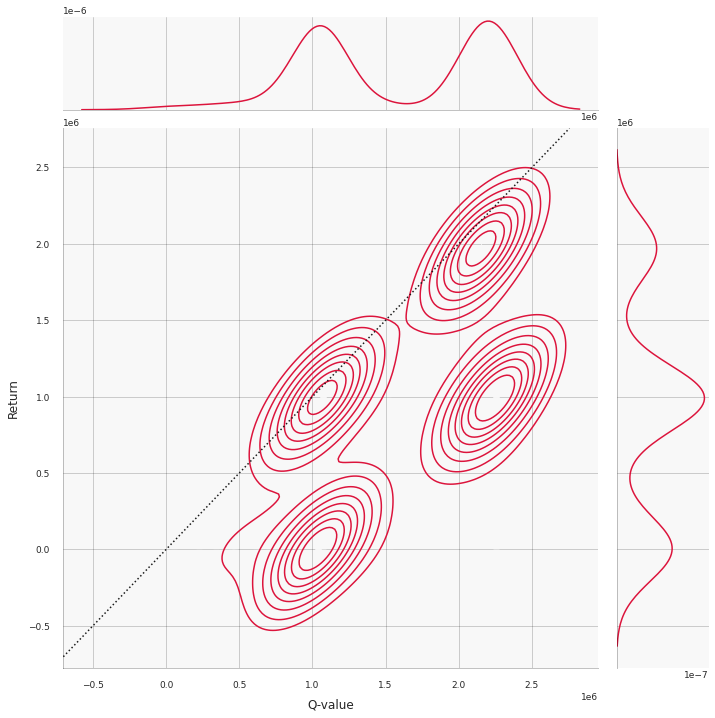

In [ ]:
# Visualizing the distribution of Q-value vs actual returns 

values = np.reshape(q_values_rewards_trace, (num_episodes * T, 2, ))

df = pd.DataFrame(data=values, columns=['Q-value', 'Return'])
g = sns.jointplot(x="Q-value", y="Return", data=df, kind="kde", color="crimson", height=10, aspect=1.0)
g.plot_joint(plt.scatter, c="w", s=30, linewidth=1, marker="+", alpha=0.1)
g.ax_joint.collections[0].set_alpha(0)

x0, x1 = g.ax_joint.get_xlim()
y0, y1 = g.ax_joint.get_ylim()
lims = [max(x0, y0), min(x1, y1)]
g.ax_joint.plot(lims, lims, ':k')   

g.savefig("output.png")

In [ ]:
 pip install keras-rl

     |████████████████████████████████| 40kB 3.4MB/s 
  Created wheel for keras-rl: filename=keras_rl-0.4.2-cp37-none-any.whl size=48380 sha256=f7464901c9e6853a5a1ac81e879d273cd96aa287542d43303c5fd2aaebf677e2
  Stored in directory: /root/.cache/pip/wheels/7d/4d/84/9254c9f2e8f51865cb0dac8e79da85330c735551d31f73c894
Successfully built keras-rl


In [ ]:
pip install gym

In [ ]:
import numpy as np
import gym

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

In [ ]:
ENV_NAME = 'CartPole-v0'
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

In [ ]:
import tensorflow as tf

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
model.compile(optimizer='adam',
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
print(model.summary())


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 4)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                80        
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 34        
_________________________________________________________________
activation_7 (Activation)    (None, 2)                 0         
Total params: 114
Trainable params: 114
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
#https://colab.research.google.com/drive/1x2tAyAai4NK5Wfb0GD3LTZLxj2ysylxE?usp=sharing

In [ ]:
#**voy intentar crear mi entorno y ver si puedo aplicar un mejor análisis de costes/benefícios

In [ ]:
class Price(gym.Env):
  """intentanto crear mi entorno"""
  metadata = {'render.modes': ['price']}
  def __init__(self, df):
    super(PriceEnv, self).__init__()
    self.df = df
    self.reward_range = (0, MAX_PROFIT) 
    # Actions of the format Viaja x%, Noviaja x%
    self.action_space = spaces.Box(
      low=np.array([0, 0]), high=np.array([3, 1]), dtype=np.float16)
    # Prices contains the OHCL values for the last five prices
    self.observation_space = spaces.Box(
      low=0, high=1, shape=(6, 6), dtype=np.float16)

In [ ]:
def reset(self):
  # Reset 
  self.balance = INITIAL_PROFIT
  self.net_worth = INITIAL_PROFIT
  self.max_net_worth = INITIAL_PROFIT
  self.travel_held = 0
  self.cost_basis = 0
  self.total_travelled = 0
  self.total_profit = 0
 
  # Set the current step to a random point within the data frame
  self.current_step = random.randint(0, len(self.df.loc[:, 'Open'].values) - 6)
  return self._next_observation()

In [ ]:
def _next_observation(self):
  # Get the data points for the last 5 days and scale to between 0-1
  frame = np.array([
    self.df.loc[self.current_step: self.current_step +
                5, 'Open'].values / MAX_PROFIT,
    self.df.loc[self.current_step: self.current_step +
                5, 'High'].values / MAX_PROFIT,
    self.df.loc[self.current_step: self.current_step +
                5, 'Low'].values / MAX_PROFIT,
    self.df.loc[self.current_step: self.current_step +
                5, 'Close'].values / MAX_PROFIT,
    self.df.loc[self.current_step: self.current_step +
                5, 'Volume'].values / MAX_TRAVELLED,
   ])
  # Append additional data and scale each value to between 0-1
  obs = np.append(frame, [[
    self.balance / MAX_PROFIT,
    self.max_net_worth / MAX_PROFIT,
    self.travel_held / MAX_TRAVELLED,
    self.cost_basis / MAX_TRAVELLED,
    self.total_travelled / MAX_TRAVELLED,
    self.total_profit / (MAX_PROFIT * MAX_TRAVELLED),
  ]], axis=0)
  return obs

 

In [ ]:
def step(self, action):
  # Execute one time step within the environment
  self._take_action(action)
  self.current_step += 1
  if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
    self.current_step = 0
  delay_modifier = (self.current_step / MAX_STEPS)
  
  reward = self.balance * delay_modifier
  done = self.net_worth <= 0
  obs = self._next_observation()
  return obs, reward, done, {}

In [ ]:
def _take_action(self, action):
  # Set the current price to a random price within the time step
  current_price = random.uniform(
    self.df.loc[self.current_step, "Viaja"],
    self.df.loc[self.current_step, "Noviaja"])
  action_type = action[0]
  amount = action[1]
  if action_type < 1:
    # Buy amount % of balance in shares
    total_possible = self.balance / current_price
    shares_bought = total_possible * amount
    prev_cost = self.cost_basis * self.shares_held
    additional_cost = shares_bought * current_price
    self.balance -= additional_cost
    self.cost_basis = (prev_cost + additional_cost)/(self.shares_held + shares_bought)
    self.shares_held += shares_bought
  elif actionType < 2:
    # Sell amount % of shares held
    shares_sold = self.shares_held * amount 
    self.balance += shares_sold * current_price
    self.shares_held -= shares_sold
    self.total_shares_sold += shares_sold
    self.total_sales_value += shares_sold * current_price
  self.netWorth = self.balance + self.shares_held * current_price
  if self.net_worth > self.max_net_worth:
    self.max_net_worth = net_worth
  if self.shares_held == 0:
    self.cost_basis = 0


In [ ]:
def render(self, mode='price', close=False):
  # Render the environment to the screen
  profit = self.net_worth - INITIAL_ACCOUNT_BALANCE
  print(f'Step: {self.current_step}')
  print(f'Balance: {self.balance}')


In [ ]:
import gym
import json
import datetime as dt
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import PPO2
from env.StockTradingEnv import StockTradingEnv
import pandas as pd
df = pd.read_csv('./data/AAPL.csv')
df = df.sort_values('Date')
# The algorithms require a vectorized environment to run
env = DummyVecEnv([lambda: StockTradingEnv(df)])
model = PPO2(MlpPolicy, env, verbose=1)
model.learn(total_timesteps=20000)
obs = env.reset()
for i in range(2000):
  action, _states = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  env.render()